In [191]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [192]:
import sys
sys.path.append('../Code/')

In [193]:
from sklearn.metrics import roc_auc_score
from utils import new_performance
import keras as K

class roc_callback(K.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [194]:
from keras import backend as K
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# Setup

In [5]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import performance

import os
DATA_DIR = os.path.join('../..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [6]:
def timtime(t):
    print(">",int(time.time()- t), "seconds elapsed")

# Load data

In [225]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))
if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [226]:
#not included originally 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_X)
train_X=scaler.transform(train_X)
valid_X=scaler.transform(valid_X)
test_X=scaler.transform(test_X)

In [10]:
test_budget=625000

In [11]:
train_budget = (test_budget*len(train_X))//len(test_X)

In [12]:
train_budget

5008201

# CTR estimation

### GBDT

In [227]:
test_X_arr=test_X

In [13]:
valid_X_arr=valid_X

In [14]:
train_y_click=np.array(train_y.click,dtype=float)

In [15]:
valid_y_click=np.array(valid_y.click,dtype=float)

In [16]:
train_X_arr=train_X

## MODEL 1 - BASIC NN



In [20]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(train_y_click), train_y_click)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

numpy.random.seed(7)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop,roc_callback(training_data=(train_X_arr, train_y_click),validation_data=(valid_X_arr, valid_y_click))]


In [25]:
model = Sequential()
model.add(Dense(100, input_dim=823, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy',             
                           recall,
                          precision])
model.fit(train_X_arr, train_y_click, validation_data=(valid_X_arr, valid_y_click), epochs=3, 
          batch_size=256,callbacks=callbacks_list,class_weight=class_weight)

Train on 2430981 samples, validate on 303925 samples
Epoch 1/3
roc-auc: 0.8708 - roc-auc_val: 0.7927                                                                                                    
2430981/2430981 [==============================] - 529s 218us/step - loss: 0.0058 - acc: 0.9993 - recall: 0.0039 - precision: 0.0044 - val_loss: 0.0048 - val_acc: 0.9993 - val_recall: 0.0063 - val_precision: 0.0067
Epoch 2/3
roc-auc: 0.9075 - roc-auc_val: 0.8235                                                                                                    
2430981/2430981 [==============================] - 451s 185us/step - loss: 0.0049 - acc: 0.9993 - recall: 0.0121 - precision: 0.0130 - val_loss: 0.0045 - val_acc: 0.9993 - val_recall: 0.0105 - val_precision: 0.0110
Epoch 3/3
roc-auc: 0.9221 - roc-auc_val: 0.8197                                                                                                    
2430981/2430981 [==============================] - 499s 205us/step - loss

#with class weights 
model.fit(train_X_arr, train_y_click, validation_data=(valid_X_arr, valid_y_click), epochs=1, batch_size=256,callbacks=callbacks_list,class_weight=class_weight)

In [37]:
valid_ctr_pred=model.predict_proba(valid_X_arr)

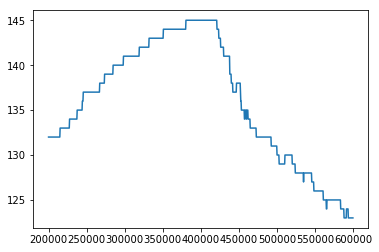

Best number of clicks: 145.0
Best base bid: 380580.580581


In [40]:
### now try a smaller range of values

min_base_bid = 2e5
max_base_bid = 6e5
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

In [41]:
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

Best number of clicks: 145.0
Best base bid: 380580.580581


In [42]:
bids = base_bid[np.argmax(clicks)]*valid_ctr_pred
new_performance(bids, valid_y)

#0.07 CTR for XG Boost 

               CTR: (0.1636)%
        num_clicks: 145
             spend: 5873098 (93.97)%
              aCPM: 19.3241687916
              aCPC: 40.5041241379
num_in_budget_wins: 88620
 ads_within_budget: 303925


(0.16361995034980817,
 145,
 5873098,
 19.324168791642673,
 40.504124137931036,
 88620,
 303925)

## MODEL 2 - Deeper

In [64]:
from keras.layers import Dropout,BatchNormalization
from keras.initializers import glorot_normal
model2 = Sequential([
    Dense(units=200, kernel_initializer=glorot_normal(seed=0), input_dim=823, activation='relu'),
    BatchNormalization(),
    Dense(units=100, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    BatchNormalization(),
    Dense(50, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    BatchNormalization(),
    Dense(10, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    Dense(1, kernel_initializer=glorot_normal(seed=0), activation='sigmoid')
])

# model2 = Sequential([
#     Dense(units=200, kernel_initializer='uniform', input_dim=823, activation='relu'),
#     Dense(units=50, kernel_initializer='uniform', activation='relu'),
#     Dropout(0.25),
#     Dense(50, kernel_initializer='uniform', activation='relu'),
#     Dense(200, kernel_initializer='uniform', activation='relu'),
#     Dense(1, kernel_initializer='uniform', activation='sigmoid')
# ])
checkpointer = ModelCheckpoint(filepath="model.deepnn",
                               verbose=0,
                               save_best_only=True)

In [65]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy',recall,precision])

In [66]:

history = model2.fit(train_X_arr, train_y_click, 
                     validation_data=(valid_X_arr, valid_y_click), 
                     epochs=3, batch_size=256,
                     callbacks=[checkpointer,earlystop,roc_callback(training_data=(train_X_arr, train_y_click),validation_data=(valid_X_arr, valid_y_click))],
                     class_weight=class_weight).history

Train on 2430981 samples, validate on 303925 samples
Epoch 1/3
roc-auc: 0.863 - roc-auc_val: 0.8269                                                                                                    
2430981/2430981 [==============================] - 735s 302us/step - loss: 0.0077 - acc: 0.9985 - recall: 1.5796e-04 - precision: 4.0503e-06 - val_loss: 0.0044 - val_acc: 0.9993 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
roc-auc: 0.8917 - roc-auc_val: 0.8267                                                                                                    
2430981/2430981 [==============================] - 714s 294us/step - loss: 0.0048 - acc: 0.9993 - recall: 4.7388e-04 - precision: 5.2654e-04 - val_loss: 0.0043 - val_acc: 0.9993 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/3
roc-auc: 0.9267 - roc-auc_val: 0.8434                                                                                                    
2430981/2430981 [=========================

In [67]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'val_recall', 'val_precision', 'loss', 'acc', 'recall', 'precision'])

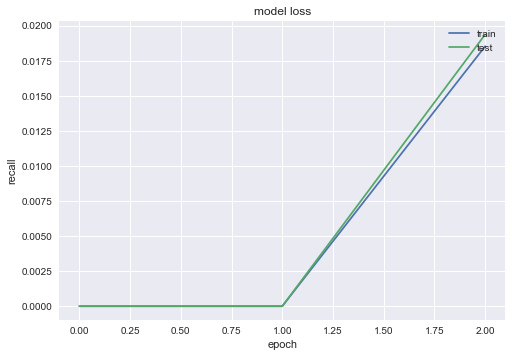

In [68]:
plt.plot(history['val_recall'])
plt.plot(history['val_precision'])
plt.title('model loss')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [78]:
valid_ctr_pred=model2.predict_proba(valid_X_arr)

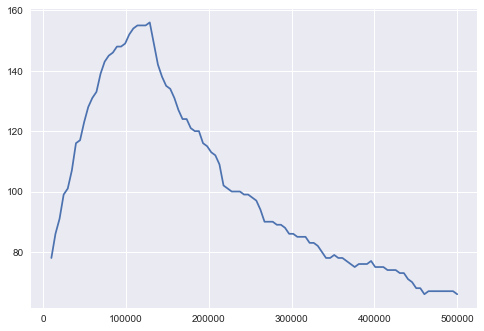

Best number of clicks: 156.0
Best base bid: 128787.878788


In [74]:
### now try a smaller range of values
min_base_bid = 1e4
max_base_bid = 5e5
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

In [79]:
new_performance(base_bid[np.argmax(clicks)]*valid_ctr_pred, valid_y)

               CTR: (0.1302)%
        num_clicks: 156
             spend: 6219251 (99.51)%
              aCPM: 20.4631109649
              aCPC: 39.8669935897
num_in_budget_wins: 119821
 ads_within_budget: 303925


(0.13019420635781706,
 156,
 6219251,
 20.463110964876204,
 39.866993589743593,
 119821,
 303925)

# Model 3 Basic Autoencoder 

In [84]:
model = Sequential([
    Dense(units=40, kernel_initializer=glorot_normal(seed=0), input_dim=823, activation='relu'),
    Dense(units=30, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    Dropout(0.25),
    Dense(30, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    Dense(40, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    Dense(1, kernel_initializer=glorot_normal(seed=0), activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy',             
                           recall,
                          precision])
checkpointer = ModelCheckpoint(filepath="model.aebasic",
                               verbose=0,
                               save_best_only=True)

model.fit(train_X_arr, train_y_click, validation_data=(valid_X_arr, valid_y_click), epochs=3, 
          batch_size=256,callbacks=callbacks_list,class_weight=class_weight)

Train on 2430981 samples, validate on 303925 samples
Epoch 1/3
roc-auc: 0.8659 - roc-auc_val: 0.7957                                                                                                    
2430981/2430981 [==============================] - 472s 194us/step - loss: 0.0070 - acc: 0.9989 - recall: 2.1061e-04 - precision: 1.0635e-04 - val_loss: 0.0047 - val_acc: 0.9993 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
roc-auc: 0.8882 - roc-auc_val: 0.8139                                                                                                    
2430981/2430981 [==============================] - 467s 192us/step - loss: 0.0051 - acc: 0.9993 - recall: 0.0061 - precision: 0.0067 - val_loss: 0.0044 - val_acc: 0.9993 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/3
1580800/2430981 [==================>...........] - ETA: 1:46 - loss: 0.0049 - acc: 0.9993 - recall: 0.0086 - precision: 0.0093

KeyboardInterrupt: 

In [80]:
valid_ctr_pred=model.predict_proba(valid_X_arr)

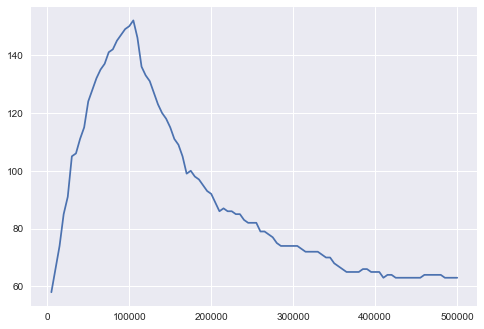

Best number of clicks: 152.0
Best base bid: 105000.0


In [82]:
### now try a smaller range of values

min_base_bid = 5e3
max_base_bid = 5e5
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

In [83]:
new_performance(base_bid[np.argmax(clicks)]*valid_ctr_pred, valid_y)

               CTR: (0.1283)%
        num_clicks: 152
             spend: 6191096 (99.06)%
              aCPM: 20.3704729785
              aCPC: 40.7308947368
num_in_budget_wins: 118472
 ads_within_budget: 303925


(0.12830035789047201,
 152,
 6191096,
 20.370472978530888,
 40.730894736842103,
 118472,
 303925)

# Fraud Detection Inspired Model, VAE

In [85]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import metrics


In [87]:
X_train=train_X_arr[train_y_click==0]

In [93]:
input_dim = X_train.shape[1]
encoding_dim = 100

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [94]:
nb_epoch = 3 #try larger
batch_size = 128
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.autov2",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(valid_X_arr, valid_X_arr),
                    verbose=1,
                    callbacks=[checkpointer, earlystop,tensorboard]).history

Train on 2429188 samples, validate on 303925 samples
Epoch 1/5
2429188/2429188 [==============================] - 247s 102us/step - loss: 0.7725 - acc: 0.3613 - val_loss: 0.7184 - val_acc: 0.3957
Epoch 2/5
2429188/2429188 [==============================] - 246s 101us/step - loss: 0.6865 - acc: 0.4014 - val_loss: 0.6923 - val_acc: 0.4073
Epoch 3/5
2429188/2429188 [==============================] - 248s 102us/step - loss: 0.6665 - acc: 0.4167 - val_loss: 0.6723 - val_acc: 0.4177
Epoch 4/5
2429188/2429188 [==============================] - 247s 102us/step - loss: 0.6551 - acc: 0.4218 - val_loss: 0.6666 - val_acc: 0.4189
Epoch 5/5
2429188/2429188 [==============================] - 205s 85us/step - loss: 0.6486 - acc: 0.4234 - val_loss: 0.6587 - val_acc: 0.4256


In [ ]:
#load model 

# autoencoder = load_model('model.h5')


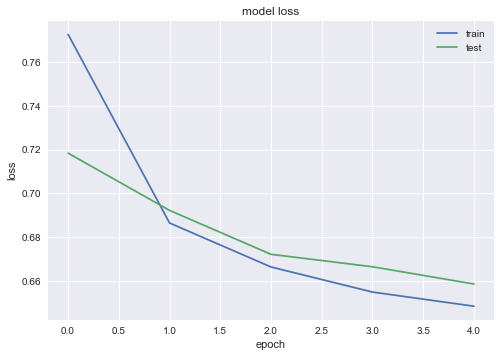

In [95]:
#Plot Evaluation

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [100]:
#Plot Evaluation

predictions = autoencoder.predict(valid_X_arr)
mse = np.mean(np.power(valid_X_arr - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': valid_y_click})
error_df.describe()

,reconstruction_error,true_class
count,303925.000000,303925.000000
mean,0.560290,0.000665
std,6.000011,0.025772
min,0.019160,0.000000
25%,0.123410,0.000000
50%,0.276425,0.000000
75%,0.619166,0.000000
max,2956.928632,1.000000


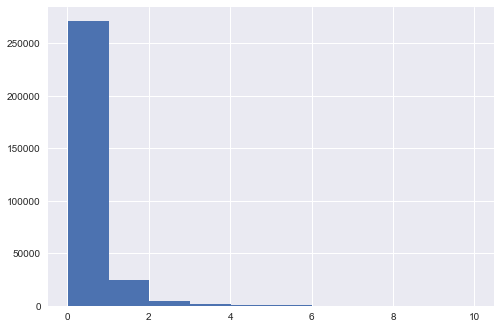

In [102]:
#without clicks 

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.show()

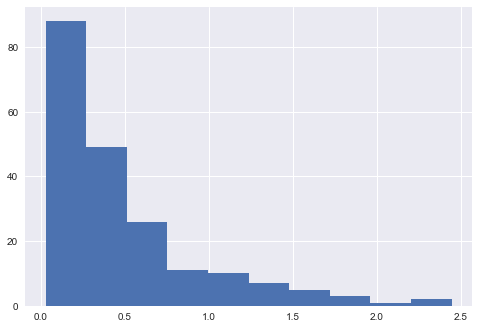

In [103]:
#with clicks

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.show()

In [104]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

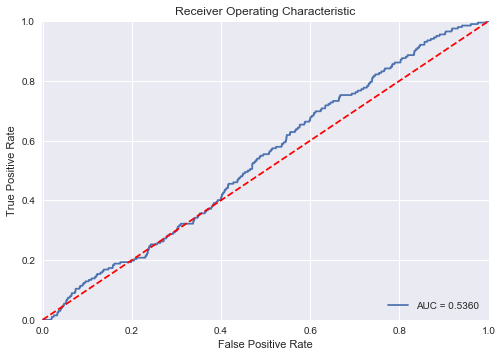

In [105]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

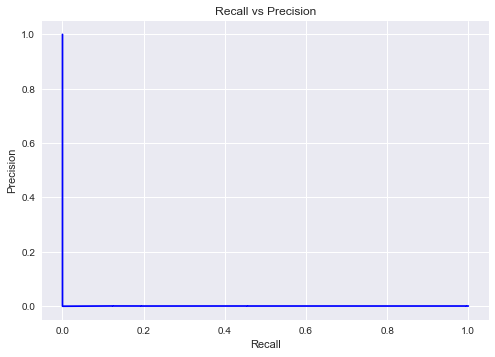

In [106]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

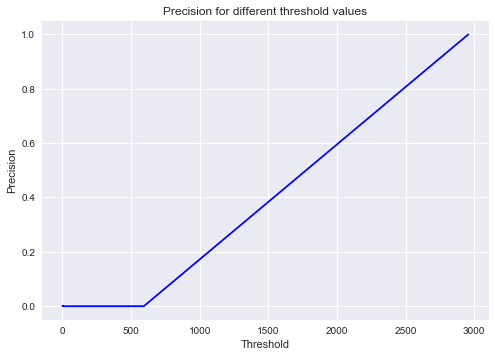

In [107]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

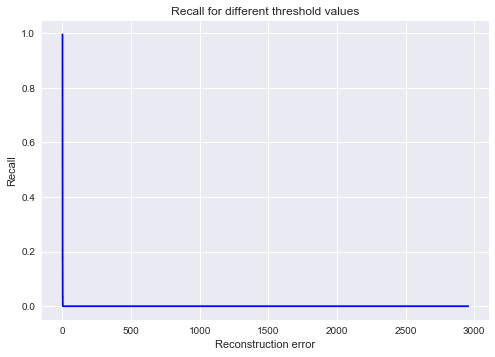

In [108]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

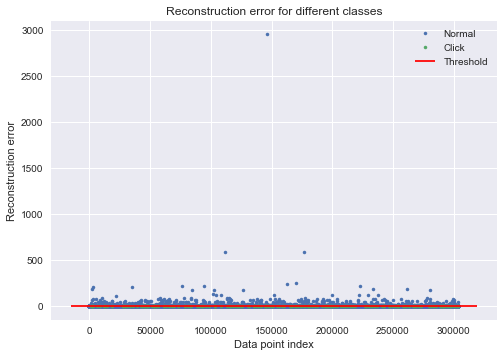

In [110]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Click" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [111]:
LABELS = ["Normal", "Click"]


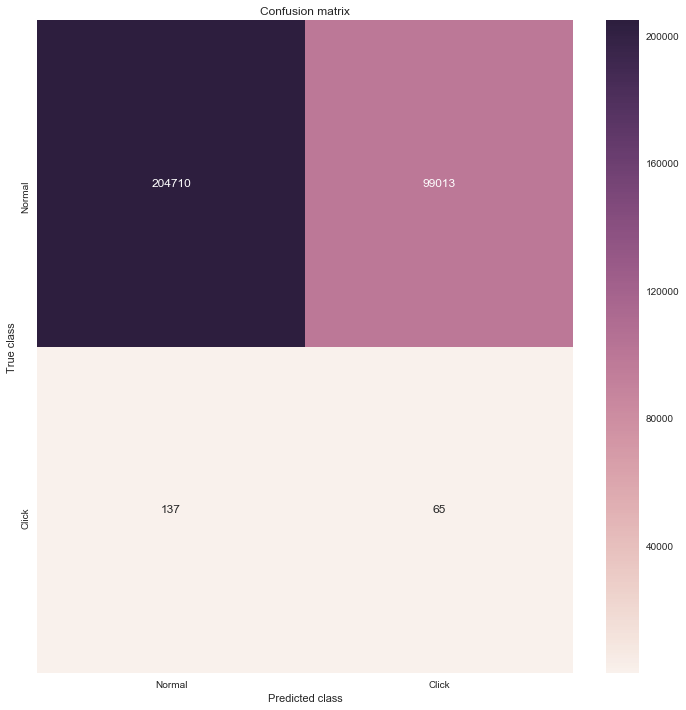

In [112]:
threshold = 0.5
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [113]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [125]:
y_pred = [sigmoid(np.log(e)) for e in error_df.reconstruction_error.values]
t=[e for e in error_df.reconstruction_error.values]
y_pred2=[e for e in error_df.reconstruction_error.values]
sig1=[sigmoid(e) for e in error_df.reconstruction_error.values]
sig2=[sigmoid(e-0.5) for e in error_df.reconstruction_error.values]

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(y_pred2)
y_pred2=scaler.transform(np.array(y_pred2).reshape((-1,1)))

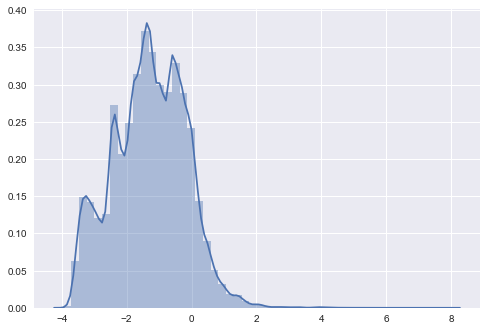

In [118]:
#logged 

import seaborn as sns 
sns.distplot(np.log(t))
plt.show()

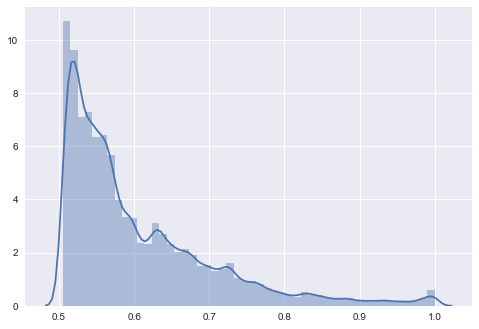

In [122]:
#sigmoid 

import seaborn as sns 
sns.distplot(sig)
plt.show()

In [136]:
y_pred_probs=np.array(y_pred,dtype=float)

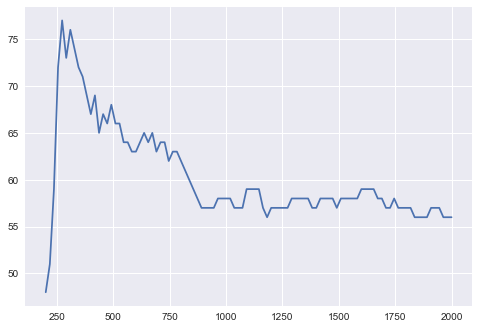

Best number of clicks: 77.0
Best base bid: 272.727272727


In [139]:
### now try a smaller range of values 77 best with y_pred

min_base_bid = 2e2
max_base_bid = 2e3
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*y_pred_probs
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

In [140]:
new_performance(base_bid[np.argmax(clicks)]*y_pred_probs, valid_y)

               CTR: (0.0544)%
        num_clicks: 77
             spend: 6249857 (100.00)%
              aCPM: 20.7222688254
              aCPC: 81.166974026
num_in_budget_wins: 141615
 ads_within_budget: 301601


(0.054372771245983831,
 77,
 6249857,
 20.722268825368616,
 81.166974025974028,
 141615,
 301601)

# Neural CTR and Payprice Predictor 

In [178]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [169]:
train_y_payprice=np.array(train_y.payprice,dtype=float)
valid_y_payprice=np.array(valid_y.payprice,dtype=float)

In [170]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_y_payprice.reshape((-1,1)))
train_y_payprice=scaler.transform(np.array(train_y_payprice).reshape((-1,1)))
valid_y_payprice=scaler.transform(np.array(valid_y_payprice).reshape((-1,1)))

In [183]:
model3 = Sequential()
model3.add(Dense(100, input_dim=823, activation='tanh'))
model3.add(Dense(1, activation='sigmoid'))




In [184]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.neuralbid",
                               verbose=0,
                               save_best_only=True)


# Train Best Model

In [199]:
from keras.layers import Dropout,BatchNormalization
from keras.initializers import glorot_normal
model2 = Sequential([
    Dense(units=200, kernel_initializer=glorot_normal(seed=0), input_dim=823, activation='relu'),
    BatchNormalization(),
    Dense(units=100, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    BatchNormalization(),
    Dense(50, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    BatchNormalization(),
    Dense(10, kernel_initializer=glorot_normal(seed=0), activation='relu'),
    Dense(1, kernel_initializer=glorot_normal(seed=0), activation='sigmoid')
])

# model2 = Sequential([
#     Dense(units=200, kernel_initializer='uniform', input_dim=823, activation='relu'),
#     Dense(units=50, kernel_initializer='uniform', activation='relu'),
#     Dropout(0.25),
#     Dense(50, kernel_initializer='uniform', activation='relu'),
#     Dense(200, kernel_initializer='uniform', activation='relu'),
#     Dense(1, kernel_initializer='uniform', activation='sigmoid')
# ])
checkpointer = ModelCheckpoint(filepath="model.bestnn",
                               verbose=0,
                               save_best_only=True)

In [200]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy',recall,precision])

In [201]:

history = model2.fit(train_X_arr, train_y_click, 
                     validation_data=(valid_X_arr, valid_y_click), 
                     epochs=10, batch_size=256,
                     callbacks=[checkpointer,earlystop,roc_callback(training_data=(train_X_arr, train_y_click),validation_data=(valid_X_arr, valid_y_click))],
                     class_weight=class_weight).history

Train on 2430981 samples, validate on 303925 samples
Epoch 1/10
roc-auc: 0.8535 - roc-auc_val: 0.8191                                                                                                    ss: 0.0077 - acc: 0.9985 - recall: 0.0023 - p
2430981/2430981 [==============================] - 710s 292us/step - loss: 0.0077 - acc: 0.9985 - recall: 0.0022 - precision: 0.0024 - val_loss: 0.0044 - val_acc: 0.9993 - val_recall: 0.0034 - val_precision: 0.0034
Epoch 2/10
roc-auc: 0.8952 - roc-auc_val: 0.8207                                                                                                    ss: 0.0049 - ac
2430981/2430981 [==============================] - 745s 306us/step - loss: 0.0049 - acc: 0.9993 - recall: 0.0087 - precision: 0.0093 - val_loss: 0.0043 - val_acc: 0.9994 - val_recall: 0.0270 - val_precision: 0.0274
Epoch 3/10
roc-auc: 0.9206 - roc-auc_val: 0.8401                                                                                                    
2430981/24

In [228]:
test_pred=model2.predict_proba(test_X_arr)

In [241]:
##### save both models
import pickle
pkl_filename = "nn_valid_probs.pkl"  

with open(pkl_filename, 'wb') as file:  
    pickle.dump(valid_ctr_pred, file)
    


In [244]:
import pickle
pf = "../Models/tim_xgb_click.pkl"
with open(pf, 'rb') as file:
    GBDT = pickle.load(file)


In [246]:
XGB_price_preds = 75275.275275*GBDT.predict(valid_X)

In [247]:
valid_NN=133737.373737*valid_ctr_pred

In [248]:
XGB_price_preds

array([ 43.91756058,  43.91756058,  43.91756058, ...,  85.95770264,
        43.91756058,  70.37879181], dtype=float32)

In [249]:
valid_NN

array([[  56.25673294],
       [   9.22059441],
       [  29.485569  ],
       ..., 
       [ 351.85946655],
       [  34.45927429],
       [ 150.88995361]], dtype=float32)

In [254]:
base_blend = np.linspace(0, 1, 2)
clicks = np.zeros_like(base_bid)

for l in base_blend:
    bids = (l*valid_NN+(l-1)*XGB_price_preds)
    c= new_performance(bids, valid_y,verbose=False)[1]
#     clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

MemoryError: 

In [252]:
### now try a smaller range of values
min_base_bid = 0
max_base_bid = 1
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_NN + (1-bb)*XGB_price_preds
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

MemoryError: 

In [229]:
test_bids = 133737.373737*test_pred

In [232]:
import pandas as pd

In [234]:
submit = pd.read_csv('../../Data/Group_xx.csv')

In [236]:
submit['bidprice']=test_bids

In [237]:
submit.head()

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,142.613556
1,29167d4caa719788b5a342dbaa25151d53121f80,828.422668
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,2.427001
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,84.693230
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,60.162426


In [238]:
submit.to_csv('./NeuralPred.csv')

In [230]:
##### save both models
import pickle
pkl_filename = "test_pred.pkl"  

with open(pkl_filename, 'wb') as file:  
    pickle.dump(test_bids, file)
    
##### save predicted prices and predicted probabilities

In [240]:
valid_ctr_pred=model2.predict_proba(valid_X_arr)


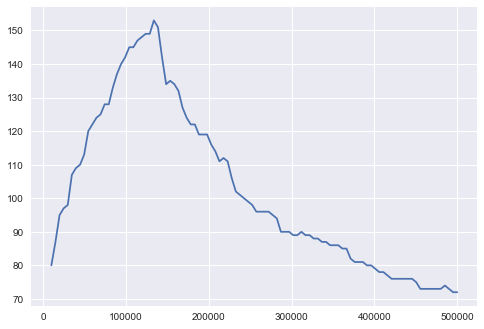

Best number of clicks: 153.0
Best base bid: 133737.373737


In [203]:
### now try a smaller range of values
min_base_bid = 1e4
max_base_bid = 5e5
n_base_bids = 100

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred
    c= new_performance(bids, valid_y,verbose=False)[1]
    clicks[i] = c
    
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

# Save best model

# Group Model 


In [204]:
from strategies import ortb_bidding_strategy #takes three arguments 
from keras.models import model_from_json


In [ ]:
# serialize model to JSON


In [215]:
p1=valid_ctr_pred*1000

In [222]:
import pickle
pkl_filename = "../Models/model2NN.pkl"  

model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.model2NN")
print("Saved model to disk")


Saved model to disk


In [223]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.model2NN")
print("Loaded model from disk")


NameError: name 'model_from_json' is not defined

In [ ]:
with open(pkl_filename, 'wb') as file:  
    pickle.(gbdt_crt_model, file)


In [224]:
lmda = np.linspace(5e-7, 1, 10)
c_val = np.linspace(0.1, 300, 10)
clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))

for i, lm in zip(range(len(lmda)), lmda):
    for j, cv in zip(range(len(c_val)), c_val):
        bids = ortb_bidding_strategy(p1*10, cv, lm, 2)
        _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
        clicks[i, j] = c

MemoryError: 

In [ ]:
##### save both models
import pickle
pkl_filename = "../Models/NN.pkl"  

with open(pkl_filename, 'wb') as file:  
    pickle.dump(gbdt_crt_model, file)
    
##### save predicted prices and predicted probabilities